In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas.plotting._matplotlib.core")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import sysconfig
from lib.zigzag import calculate_zigzag
from lib.util import load_json_candles

from tabulate import tabulate



In [2]:

import sysconfig
cmodule = 'zigzag'
f'clear & rm {cmodule}.so & gcc -shared -o {cmodule}.so -fPIC {cmodule}.c -I{sysconfig.get_path("include")} -I{np.get_include()}'

'clear & rm zigzag.so & gcc -shared -o zigzag.so -fPIC zigzag.c -I/home/mu6mula/miniconda3/envs/py311/include/python3.11 -I/home/mu6mula/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/core/include'

In [3]:
def load_data(base, quote, timeframe):
    fname = f'./data/{base}_{quote}-{timeframe}.json'
    return load_json_candles(fname)

def get_window_data(data, start_index_window, window_width):
    ws = start_index_window * window_width
    ww = window_width
    wdata = data.iloc[ws:min(len(data), ws+ww)].copy()
    return wdata



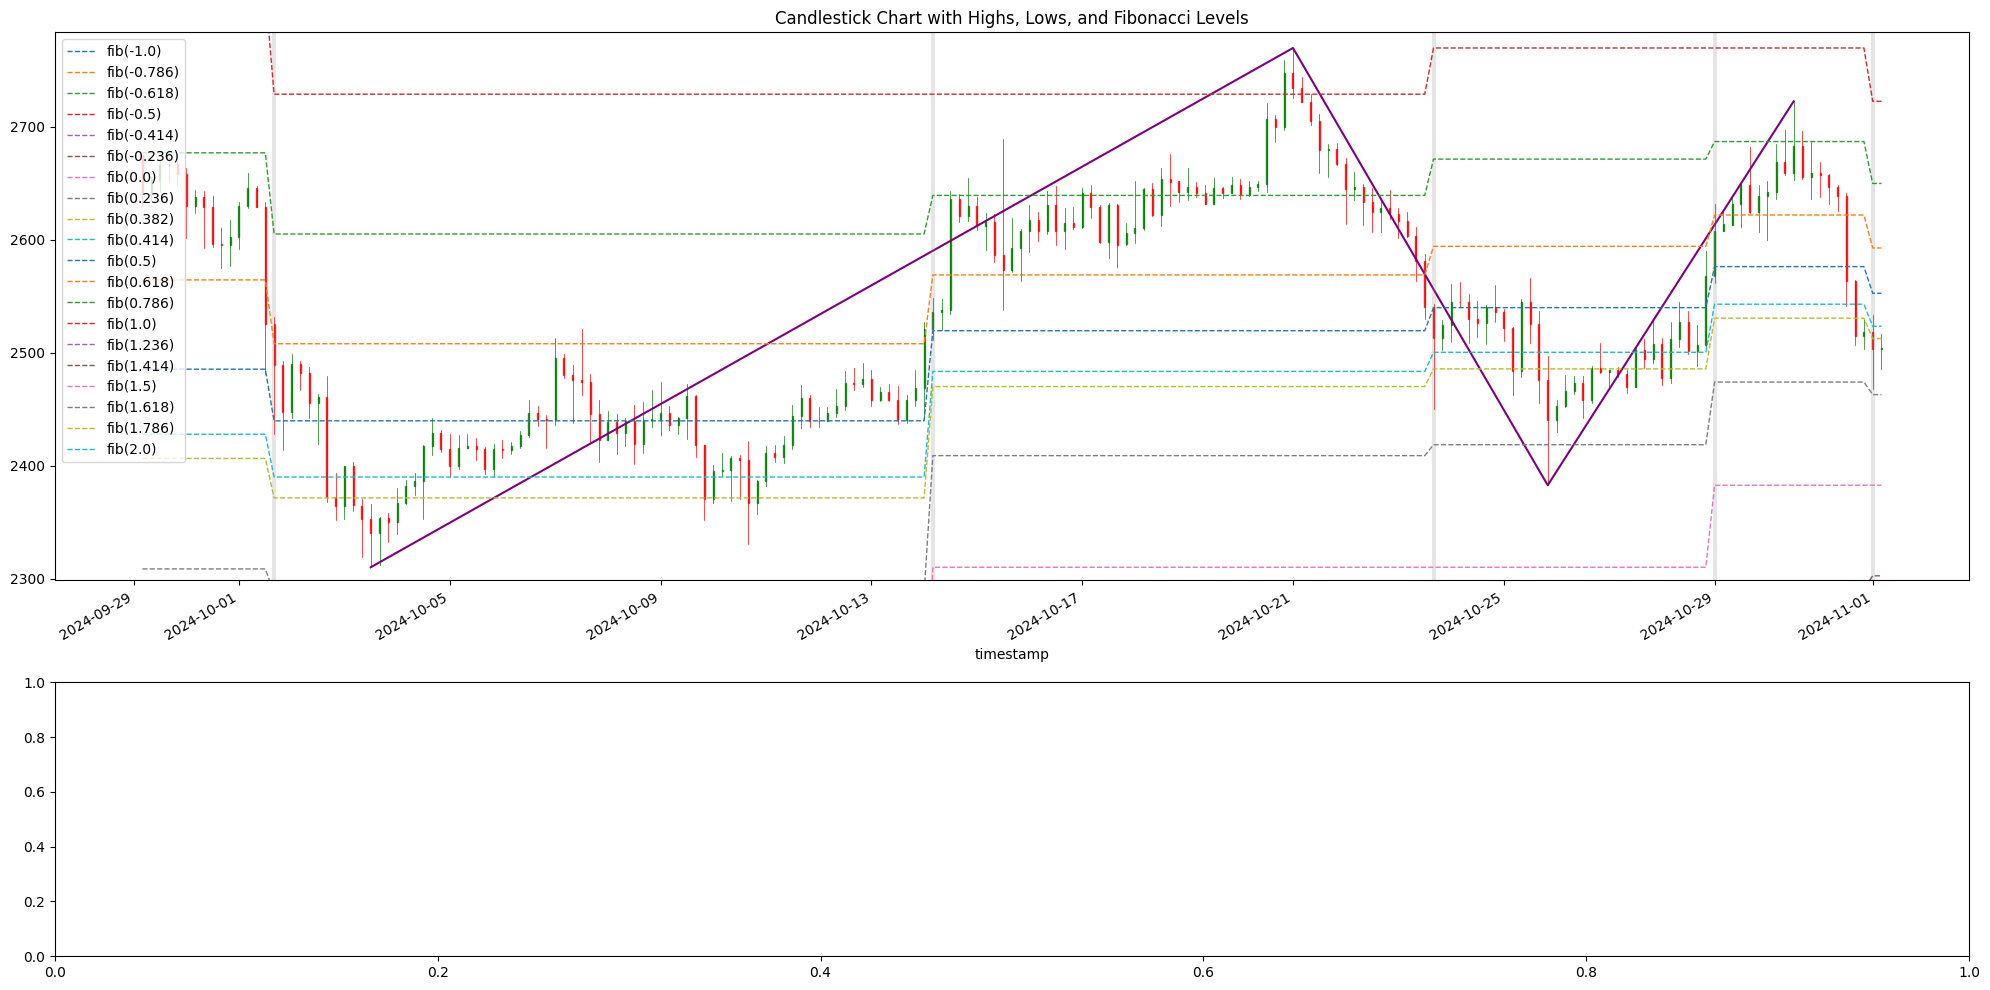

In [4]:
fib_levels = np.array([-1.0, -0.786, -0.618, -0.5, -0.414, -0.236, 0.0, 0.236, 0.382, 0.414, 0.5, 0.618, 0.786, 1.0, 1.236, 1.414, 1.5, 1.618, 1.786, 2.0])

fib_columns = [f'fib({fib})' for fib in fib_levels]

exchange,base,quote,timeframe = 'binance','ETH', 'USDT', '4h'

data = load_data(base,quote,timeframe)#.apply(np.log)
epsilon = 0.10
highs = data['high'].values
lows = data['low'].values
# highs = lows = data.close.values
# Call the calculate_zigzag function from the C module
high_low_markers, turning_markers = calculate_zigzag(highs, lows, epsilon=epsilon)

extreme_points_ix = np.where(high_low_markers != 0)[0]
extreme_points_hi_ix = np.where(high_low_markers == 1)[0]
extreme_points_lo_ix = np.where(high_low_markers == -1)[0]
extreme_points = high_low_markers[extreme_points_ix]
extreme_prices = np.where(extreme_points == 1, highs[extreme_points_ix], lows[extreme_points_ix])

turning_points_ix = np.where(turning_markers !=0)[0]
turning_points_up_ix = np.where(turning_markers == 1)[0]
turning_points_dn_ix = np.where(turning_markers == -1)[0]
# turning_extremes_ix = np.full(len(high_low_markers), np.nan)

# running_highs_idx = pd.Series(np.where(high_low_markers == 1, 1, np.nan) * np.arange(len(data)), index=data.index).ffill().values
# running_lows_idx = pd.Series(np.where(high_low_markers == -1, 1, np.nan) * np.arange(len(data)), index=data.index).ffill().values

##############################################

# fhigh_low_markers, fturning_markers = zigzag.calculate_zigzag(highs, lows, epsilon=epsilon * 1)

running_highs = pd.Series(np.where(turning_markers == 1, 1, np.nan) * highs).ffill().values
# running_lows = pd.Series(np.where(turning_markers == -1, 1, np.nan) * lows).ffill().values

running_highs = np.full(len(turning_markers), np.nan); 
running_highs[turning_points_dn_ix] = highs[extreme_points_hi_ix[:len(turning_points_dn_ix)]]; 
running_highs = pd.Series(running_highs).ffill().values
# running_highs = running_highs.ffill().values

running_lows = np.full(len(turning_markers), np.nan); 
running_lows[turning_points_up_ix] = lows[extreme_points_lo_ix[:len(turning_points_up_ix)]]; 
running_lows = pd.Series(running_lows).ffill().values
# running_lows = pd.Series(np.where(turning_markers == -1, 1, np.nan) * lows).ffill().values


diff = running_highs - running_lows
fib_matrix = np.outer(diff, fib_levels)
fib_levels_array = running_lows[:, np.newaxis] + fib_matrix
df_fibs = pd.DataFrame(fib_levels_array, columns=fib_columns, index=data.index)

run_diff = (np.cumsum(turning_markers != 0) - np.cumsum(high_low_markers != 0))

# df_fibs = df_fibs.multiply((np.where(run_diff < 0, np.nan, 1)), axis=0)
##############################################
##############################################
ws, ww = len(data)-1000, 200
wdata = data.iloc[ws:ws+ww-1].copy()

whighs = wdata.high
wlows = wdata.low

candlestick_ohlc_args={'width': .1 / np.log(len(wdata))}

##############################################
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), height_ratios=[2, 1])

wdata_index = wdata['date_num'] = mdates.date2num(wdata.index)
# Prepare the OHLC data in the format: (date, open, high, low, close)
ohlc = wdata[['date_num', 'open', 'high', 'low', 'close']].values
# Plot the candlesticks
candlestick_ohlc(ax1, ohlc, colorup='green', colordown='red', alpha=0.8, **candlestick_ohlc_args)
# Set y-axis limits based on the close price
ax1.set_ylim(wlows.min()*0.995, whighs.max()*1.005)

# Format the x-axis to show dates
ax1.xaxis_date()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_title('Candlestick Chart with Highs, Lows, and Fibonacci Levels')
# ax1.legend()
wturning_points_ix = turning_points_ix[(turning_points_ix >= ws) & (turning_points_ix <= ws + ww - 1)]
wextreme_points_ix = extreme_points_ix[(extreme_points_ix >= ws) & (extreme_points_ix <= ws + ww - 1)]
wextreme_points = high_low_markers[wextreme_points_ix]
wextreme_prices = np.where(wextreme_points == 1, highs[wextreme_points_ix], lows[wextreme_points_ix])

# turning_dates = mdates.date2num(wdata.loc[turning_points_idx].index)
ax1.plot(mdates.date2num(data.index[wextreme_points_ix]), wextreme_prices, color='purple', label='ZigZag Line', lw=1.5)
for ix in wturning_points_ix:
    ax1.axvline(data.index.values[ix], color='gray', linestyle='-', alpha=0.2, lw=3)

df_fibs.loc[wdata.index].plot(ax=ax1, linestyle='--', lw=1)

plt.tight_layout()
plt.savefig('output.png')
plt.show()


In [5]:
' '.join(map(str,list(enumerate(fib_levels))))

'(0, -1.0) (1, -0.786) (2, -0.618) (3, -0.5) (4, -0.414) (5, -0.236) (6, 0.0) (7, 0.236) (8, 0.382) (9, 0.414) (10, 0.5) (11, 0.618) (12, 0.786) (13, 1.0) (14, 1.236) (15, 1.414) (16, 1.5) (17, 1.618) (18, 1.786) (19, 2.0)'

In [9]:
# ldata = data.apply(np.log)
# ldf_fibs = df_fibs.apply(np.log)

log_level_entry = data.close.apply(np.log)

hold_period = 6
fu_min = data.low.rolling(hold_period).min().shift(-hold_period)
fu_max = data.high.rolling(hold_period).max().shift(-hold_period)
fu_eop = data.close.shift(-hold_period)
# fu_lmin = ldata.low.rolling(hold_period).min().shift(-hold_period)
# fu_lmax = ldata.high.rolling(hold_period).max().shift(-hold_period)
# fu_leop = ldata.close.shift(-hold_period)

# a + 0.2 * (b - a) = a + 0.2b - 0.2a = (1-0.2)a + 0.2b
pos_sign =  1
# stoploss_fib = 'fib(0.382)'
current_fib = 'fib(0.414)'
target_fib = 'fib(0.786)'
wick_k = 0.1

signal = (data.low < df_fibs[current_fib] - wick_k * (df_fibs[target_fib] - df_fibs[current_fib]) ) & (data.close >= df_fibs[current_fib])

level_target = df_fibs[target_fib]
log_level_target = level_target.apply(np.log)
sl_k = .5
level_stoploss = df_fibs[current_fib] - pos_sign * sl_k * (df_fibs[target_fib] - df_fibs[current_fib])
log_level_stoploss = level_stoploss.apply(np.log)
# signal = (data.high > (df_fibs[current_fib] * (1 - wick_k) + df_fibs[next_through_fib] * wick_k) ) & (data.close < df_fibs[current_fib])

# target_hit = signal * (fu_min < df_fibs[target_fib])

target_hit = signal * (fu_max - level_target > 0)
stoploos_hit = signal * (level_stoploss - fu_min > 0)
eop_hit = signal * (1 - stoploos_hit ) * (1 - target_hit)
log_level_eop = fu_eop.apply(np.log)
num_signal = signal.sum(); num_target = (target_hit).sum(); num_stoploss = stoploos_hit.sum(); num_eop = eop_hit.sum()

part_stoploss, part_target, part_eop = num_stoploss / num_signal, num_target / num_signal, num_eop / num_signal
# Print the table
print(tabulate([
    # ['% stopped', num_stoploss / num_signal],
    ['num_signal:', num_signal],
    ['num_stoploss:', num_stoploss, 'part_stoploss:', part_stoploss],
    ['num_target:', num_target, 'part_target:', part_target],
    ['num_eop:', num_eop, 'part_eop:', part_eop]
    ], tablefmt="grid"))


# print("% stopped ", num_stoploss / num_signal) # fraction of stopped trades
# print(f'num_signal: {num_signal}', f'num_stoploss: {num_stoploss}', f'num_target: {num_target}')

+---------------+-----+----------------+----------+
| num_signal:   | 420 |                |          |
+---------------+-----+----------------+----------+
| num_stoploss: | 130 | part_stoploss: | 0.309524 |
+---------------+-----+----------------+----------+
| num_target:   | 135 | part_target:   | 0.321429 |
+---------------+-----+----------------+----------+
| num_eop:      | 174 | part_eop:      | 0.414286 |
+---------------+-----+----------------+----------+


In [ ]:
log_level_stoploss = level_stoploss.apply(np.log)

stoploss_lrets = (pos_sign * stoploos_hit * (log_level_stoploss - ldata.close)).apply(np.expm1)
target_lrets = (pos_sign * target_hit * (level_target - ldata.close)).apply(np.expm1)
eop_lrets = (pos_sign * eop_hit * (level_eop - ldata.close)).apply(np.expm1)
# ((lsl - ldata.close) / (ldata.close - ldf_fibs[target_fib])).describe()
# stopped
target_hit.sum(), stopped.sum(), eop_hit.sum()

% stopped:  0.7202898550724638


(186, 497, 89)

In [58]:

target_lrets.sum(), stopped_lrets.sum(), eop_lrets.sum()

(-6.290830605732386, 5.398716647945529, -1.3856251850736747)

<Axes: xlabel='timestamp'>

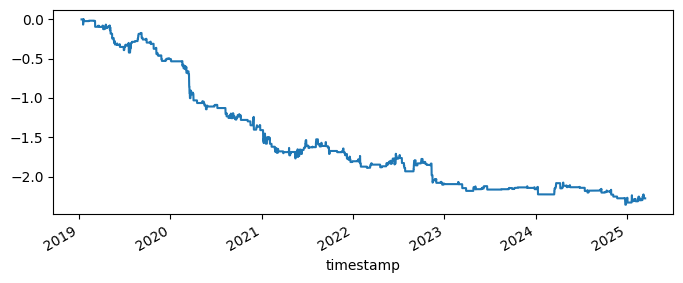

In [57]:
trades = (target_lrets + stopped_lrets + eop_lrets)
trades.cumsum().plot(figsize=(8,3))

In [ ]:
signal.multiply(target_hit + stopped).sum(), signal.sum()